# CNN - MLP - train model with regression problematic 

In [1]:
def mlp_lr_sm(paths, features, y_label, networks, stations, climates,use_date_as_var, ndvi_low, ndvi_high, allow_frozen_state,loss_function, optimizer, metrics, save_to):
    """
    Arguments:
    """
    
    
    # Import modules
    from glob import glob
    import datetime as dt
    import geopandas as gpd
    import pandas as pd
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    
    ## Initialize data
    # Files with data
    paths = glob(paths)
    paths.sort()

    # Create Station id linked with filepath
    ids = [x.split('\\')[-1].split('_')[0] for x in paths]
    files = dict(zip(ids,paths))

    # Load all files into one Dataframe
    gdf = gpd.tools.util.pd.concat(map(gpd.read_file, paths), ignore_index=True)
    print(f'Rows before preprocessing {len(gdf)}')
    
    
    ## Preprocessing
    # Set type of date column to datetime object
    gdf.date = gdf.date.astype('datetime64[ns]')
    
    #Drop rows without Sentinel 2 data
    gdf.dropna(how='any',subset=['NDVI'], inplace=True)
    
    # Convert int to timedelta in days 
    s2_timedelta = [dt.timedelta(days=x) for x in gdf.s2_distance]  
    gdf.s2_distance = s2_timedelta
    
    #Remove uneseccary columns
    gdf.drop(labels = ['CloudMask'], axis = 1, inplace = True)

    # Clean Nan Values within subset columns (major variables to inspect)
    gdf.dropna(how='any', subset=['soil_moisture', 'VV'], inplace=True)

    # Drop lower and upper 1% of data to eliminate outliers
    gdf = gdf[gdf.soil_moisture.gt(gdf.soil_moisture.quantile(0.01)) & gdf.soil_moisture.lt(gdf.soil_moisture.quantile(0.99))]
    gdf = gdf[gdf.VV.gt(gdf.VV.quantile(0.01)) & gdf.VV.lt(gdf.VV.quantile(0.99))]
    gdf = gdf[gdf.NDVI.gt(gdf.NDVI.quantile(0.01)) & gdf.NDVI.lt(gdf.NDVI.quantile(0.99))]

    # Remove rows where ndvi is older than 30days
    gdf = gdf[gdf.s2_distance.gt(dt.timedelta(days=-7)) & gdf.s2_distance.lt(dt.timedelta(days=7))]
    
    # Remove NDVI values outside range because to high ndvi means to dense vegetation and vv is disturbed too much 
    if None not in [ndvi_low, ndvi_high]:
        gdf = gdf[gdf.NDVI.between(ndvi_low,ndvi_high)]
    
    # Remove rows where Temperature is below Zero 273,15 K because VV is in frozen soils not trustworth
    if allow_frozen_state == 'no':
        gdf = gdf[gdf.minimum_2m_air_temperature.gt(273,15)]

    # Choose only specififed Network
    if networks is not None:
        gdf = gdf[gdf['network'].isin(networks)]
    
    # Choose only specified Stations
    if stations is not None:
        gdf = gdf[gdf['station'].isin(stations)]
        
    # Choose only specified climate after Köpping https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification
    if climates is not None:
        gdf = gdf[gdf['climate'].isin(climates)]
    print(f'Rows after preprocessing {len(gdf)}')
    
    # Create a Variable from date convert the timestamps to delta, perform a cumulative sum on the dt feature to get a monotonically increasing value
    # For now use dayofyear 
    if use_date_as_var == True:
        #date_timedelta = [dt.timedelta(x) for x in gdf['date']]
        #date_timedelta_cumsum = np.cumsum(date_timedelta)
        gdf['day_of_year'] = gdf.date.dt.day_of_year
        
        
    ## One Hot Encoding
    gdf = pd.get_dummies(gdf, columns=["platform", "orbit"])
    
    ## Statistics
    #KDE Plot
    #plot_kde = sns.pairplot(gdf[features], diag_kind = 'kde')
    #print(plot_kde)
    
    # Dataframe Statistics 
    train_stats = gdf[features].describe()
    train_stats.pop(y_label)
    train_stats = train_stats.transpose()
    #print(train_stats)
    
    
    ## Split into Train and Test 
    df = pd.DataFrame(gdf[features]).reset_index(drop=True)
    train_df = df.sample(frac = 0.8, random_state=0)
    test_df = df.drop(train_df.index)
    
    train_labels = train_df.pop(y_label)
    test_labels = test_df.pop(y_label)
    scaler = MinMaxScaler()
    
    features.remove(y_label)
    train_df[features] = scaler.fit_transform(X = train_df[features])
    test_df[features] = scaler.fit_transform(X = test_df[features])
    
    n_train_df = train_df
    n_test_df = test_df
    
    ## Normalize data
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    
    #n_train_df = norm(train_df)
    #n_test_df = norm(test_df)

    ## The Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers
    from tensorflow.nn import relu
    #from tensorflow.nn import linear
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.optimizers import Adam
    from keras.callbacks import Callback
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow as tf
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    
    #Architecture 
    def build_model(optimizer):
        model = Sequential([
            layers.Dense(128, activation=relu, input_shape=[len(n_train_df.keys())]), # densly (fully connected) hidden layer
            layers.Dense(64, activation=relu), # denly hidden layer
            layers.Dense(1, activation='linear') #output layer
        ])

        if optimizer == 'RMSprop':
            optimizer = RMSprop(0.001)
        
        if optimizer == 'Adam':
            optimizer = Adam(.001)
        model.compile(
            loss = loss_function, # https://keras.io/api/losses/
            optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
            metrics = metrics) 

        return model
    
    model = build_model(optimizer)
    
    #Inspect Model
    model_summary = model.summary()
    
    
    ## Train the model
    # Callbacks
    """
    class Calls(Callback):
        #Print dot every epoch while training
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    """
    # stop the training when there is no improvement in the loss for three consecutive epochs.
    stop_improving = EarlyStopping(monitor='val_loss', patience=10)
    
    EPOCHS = 1000

    history = model.fit(
        x = n_train_df,
        y = train_labels,
        epochs = EPOCHS,
        validation_split = 0.2, 
        verbose = 0,
        callbacks = [stop_improving]) # Calls()
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    import matplotlib.pyplot as plt

    def plot_history(hitsory):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [m^3/m^3]')
        plt.plot(hist['epoch'], hist['mae'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [m^3/m^3^2]')
        plt.plot(hist['epoch'], hist['mse'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

    plot_history(history)
    print(f'metrics_names : {model.metrics_names}')
    loss, mae, mse, accuracy = model.evaluate(n_test_df, test_labels, verbose = 0)
    print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
    print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
    print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

    ## Make Predictions
    test_predictions = model.predict(n_test_df).flatten()
    
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values m^3/m^3')
    plt.ylabel('Predictions m^3/m^3')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,0.5])
    plt.ylim([0,0.5])
    plot_predict_scatter = plt.plot([-100,100], [-100,100])
    print(plot_predict_scatter)
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error m^3/m^3')
    plot_error_hist = plt.ylabel('Count')
    print(plot_error_hist)
    
    #Save Model
    if save_to is not None:
        model.save(save_to)

    return model, gdf

In [2]:
features_s1 = ['platform', 'orbit', 'VV', 'VH', 'angle', 'img_id'] #latform & orbit are categorical data

features_s2 = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 
               'WaterVapor', 'Cirrus', 'SWIR1', 'SWIR2', 'CloudMask', 'NDVI', 'date_y']

features_era5 = ['dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature',
                 'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation', 
                 'u_component_of_wind_10m', 'v_component_of_wind_10m']

features_ismn = ['ismn_id','soil_moisture', 'soil_moisture_flag', 'soil_moisture_orig_flag', 'network', 
                 'station', 'clay', 'sand', 'silt', 'oc', 'climate', 'elevation', 'instrument']

features_4all = ['date','day_of_year', 'geometry']

features_selected = ['day_of_year', 'VV', 'VH', 'angle', 'platform_A', 'platform_B', 'orbit_ASCENDING','orbit_DESCENDING',
                     'NDVI', 'soil_moisture']

networks_all = {'Germany' : ['TERENO'],'Austria' : ['WEGERENET']}

Rows before preprocessing 77721
Rows after preprocessing 9844
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
metrics_names : ['loss', 'mae', 'mse', 'accuracy']
Testing set Mean Abs Error:  0.05 m^3/m^3
Testing set Mean squared Error:  0.01 m^3/m^3
Testing set Accuracy:  0.00 m^3/m^3
Text(0, 0.5, 'Count')
INFO:tensorflow:Assets written to: C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm\assets


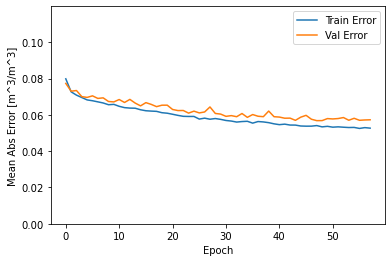

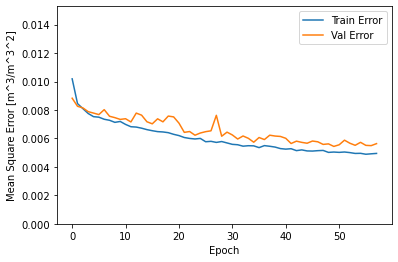

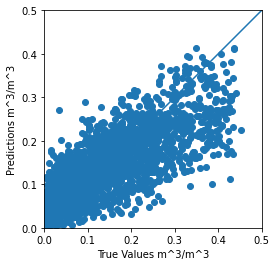

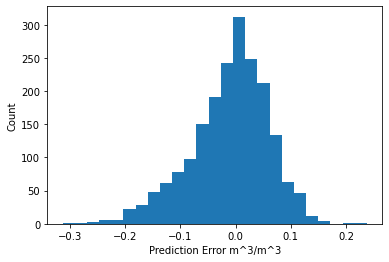

In [3]:
model, gdf = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = features_selected,
    y_label = 'soil_moisture',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.4, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm'
    )

Rows before preprocessing 67675
Rows after preprocessing 13103
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 264)               2376      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16960     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 19,401
Trainable params: 19,401
Non-trainable params: 0
_________________________________________________________________


C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


metrics_names : ['loss', 'mae', 'mse', 'accuracy']
Testing set Mean Abs Error:  0.05 m^3/m^3
Testing set Mean squared Error:  0.00 m^3/m^3
Testing set Accuracy:  0.00 m^3/m^3
Text(0, 0.5, 'Count')
INFO:tensorflow:Assets written to: C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm\assets


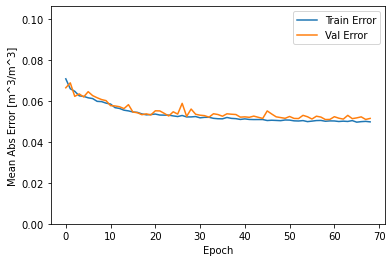

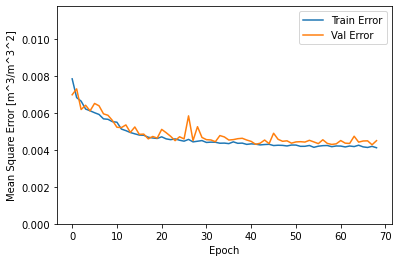

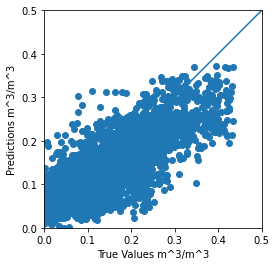

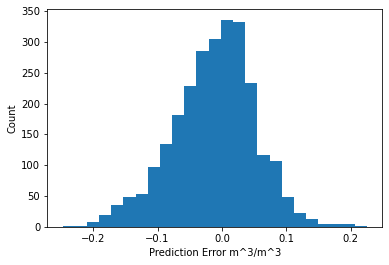

In [15]:
model_30m, gdf_30m = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data_30m/*',
    features = features_era5 + features_selected,
    y_label = 'soil_moisture',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.7, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm'
    )

In [17]:
gdf_30m[features_selected]

,day_of_year,VV,angle,platform_A,platform_B,orbit_ASCENDING,orbit_DESCENDING,NDVI,soil_moisture
128,362,-4.293795,38.799934,1,0,1,0,0.040965,0.374
156,86,-9.840509,39.156635,0,1,1,0,0.263672,0.307
157,90,-14.436690,38.345200,0,1,0,1,0.263672,0.272
158,92,-12.992417,38.807133,1,0,1,0,0.263672,0.251
159,96,-10.229556,38.414032,1,0,0,1,0.263672,0.279
...,...,...,...,...,...,...,...,...,...
67348,100,-14.793875,38.879311,0,1,1,0,0.636364,0.219
67349,104,-14.499901,38.357658,0,1,0,1,0.665287,0.220
67350,106,-16.759994,39.002361,1,0,1,0,0.665287,0.217
67351,110,-15.006778,38.383526,1,0,0,1,0.684424,0.208


In [ ]:
# Normalize data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

Merzenhausen = gdf[gdf['station'] == 'Merzenhausen'].copy()
x_Merz_values = Merzenhausen[features_selected + features_era5]
y_Merz_label = x_Merz_values.pop('soil_moisture')

train_stats = x_Merz_values.describe()
train_stats = train_stats.transpose()

x_Merz_norm = norm(x_Merz_values)
y_Merz_predict = model.predict(x_Merz_norm).flatten()
Merzenhausen['sm_predict'] = y_Merz_predict

In [ ]:
import pandas as pd
import hvplot.pandas  # noqa

pd.options.plotting.backend = 'holoviews'

In [ ]:
Merzenhausen.hvplot.scatter(x='date', y=['soil_moisture', 'sm_predict'],groupby='date.year' )

In [ ]:
import numpy as np
(Merzenhausen['soil_moisture'] - Merzenhausen['sm_predict']).sum() / 500

## Print Function names with arguments

In [ ]:
from inspect import getmembers, isfunction, signature
import numpy

def explain(m):
    try:
        return f"{m[0]}{signature(m[1])}"
    except:
        return f"{m[0]}(???)" # some functions don't provide signature

print(*(explain(m) for m in getmembers(irrigation_detection, isfunction)), sep='\n')